In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth=100

In [3]:
def jaccard_similarity(str1, str2):
    string_set1 = set(str1.split(' '))
    string_set2 = set(str2.split(' '))
    return len(string_set1.intersection(string_set2))/len(string_set2.union(string_set1))

In [4]:
# dump pkl into a pandas dataframe. 
data = pd.read_pickle('data/string_study.pkl')

In [5]:
data.head()

,atime,task,deployment,raw,dtime,msg,_info
0,1524387149611,attach-volume,wig_project_003,2018-04-22 10:52:29.611 17979 ERROR rallytester.rallytester [-] [nova attach-volume wig_project_...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-9db3-aPln:176b6fd3-8a2d-4b60-a5bd-73575c4ad...
1,1524387185889,boot-from-volume-linux,gva_shared_016,2018-04-22 10:53:05.889 25667 ERROR rallytester.rallytester [-] [nova boot-from-volume-linux gva...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested ..... cores, instances (HTTP 403) (Request-ID: re...","Quota exceeded for cores, instances: Requested 1, 1, but already used 10, 10 of 10, 10 cores, in..."
2,1524387196073,boot-linux,gva_shared_016,2018-04-22 10:53:16.073 25840 ERROR rallytester.rallytester [-] [nova boot-linux gva_shared_016]...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested ..... cores, instances (HTTP 403) (Request-ID: re...","Quota exceeded for cores, instances: Requested 1, 1, but already used 10, 10 of 10, 10 cores, in..."
3,1524387321429,boot-linux,gva_project_013,2018-04-22 10:55:21.429 19322 ERROR rallytester.rallytester [-] [nova boot-linux gva_project_013...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-15fc-N4mw:77640b75-df94-4e6d-91d6-3338fffcd...
4,1524387330897,attach-volume,gva_project_023,2018-04-22 10:55:30.897 19363 ERROR rallytester.rallytester [-] [nova attach-volume gva_project_...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-1c07-9a14:c7c5f878-2495-45bf-873d-da11b5d88...


In [8]:
data["word_count"] = data._info.apply(lambda x:len(x.split(' ')))

In [9]:
data.head()

,atime,task,deployment,raw,dtime,msg,_info,word_count
0,1524387149611,attach-volume,wig_project_003,2018-04-22 10:52:29.611 17979 ERROR rallytester.rallytester [-] [nova attach-volume wig_project_...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-9db3-aPln:176b6fd3-8a2d-4b60-a5bd-73575c4ad...,14
1,1524387185889,boot-from-volume-linux,gva_shared_016,2018-04-22 10:53:05.889 25667 ERROR rallytester.rallytester [-] [nova boot-from-volume-linux gva...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested ..... cores, instances (HTTP 403) (Request-ID: re...","Quota exceeded for cores, instances: Requested 1, 1, but already used 10, 10 of 10, 10 cores, in...",22
2,1524387196073,boot-linux,gva_shared_016,2018-04-22 10:53:16.073 25840 ERROR rallytester.rallytester [-] [nova boot-linux gva_shared_016]...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested ..... cores, instances (HTTP 403) (Request-ID: re...","Quota exceeded for cores, instances: Requested 1, 1, but already used 10, 10 of 10, 10 cores, in...",22
3,1524387321429,boot-linux,gva_project_013,2018-04-22 10:55:21.429 19322 ERROR rallytester.rallytester [-] [nova boot-linux gva_project_013...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-15fc-N4mw:77640b75-df94-4e6d-91d6-3338fffcd...,14
4,1524387330897,attach-volume,gva_project_023,2018-04-22 10:55:30.897 19363 ERROR rallytester.rallytester [-] [nova attach-volume gva_project_...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server rally-1c07-9a14:c7c5f878-2495-45bf-873d-da11b5d88...,14


In [10]:
class_by_len = set(data["word_count"])

In [11]:
class_by_len

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 72,
 73,
 81,
 118,
 749}

In [12]:
bin_len = len(class_by_len)
bin_len

45

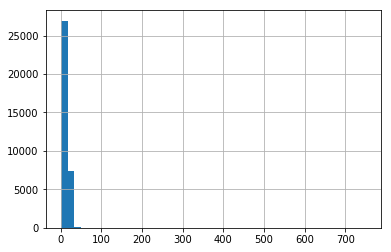

In [13]:
# Analysis of messages categorized into words
data.word_count.hist(bins = bin_len)

In [39]:
# Find the class with highest freq. 
dict = {}
for item in class_by_len:
    temp_frame = np.array(data.query("word_count == @item"))
    dict[str(item)] = len(temp_frame)

In [73]:
# The word_count with the highest frquncy is "9"
filtered_data = data.query("word_count == 19")

In [74]:
msg_array = np.array(filtered_data._info.copy())
msg_array

array(["Resource <Server: rally-03d2-Pq0H> has ERROR status.  Fault: {u'message': u'internal error: client socket is closed', u'code': 500, u'created': u'2018-04-18T19:27:28Z'}",
       "Resource <Server: rally-a7ad-kpUm> has ERROR status.  Fault: {u'message': u'internal error: client socket is closed', u'code': 500, u'created': u'2018-04-18T03:52:14Z'}",
       "Resource <Server: rally-97fb-wWlm> has ERROR status.  Fault: {u'message': u'internal error: client socket is closed', u'code': 500, u'created': u'2018-04-16T19:32:54Z'}",
       "Resource <Server: rally-119c-PZVt> has ERROR status.  Fault: {u'message': u'internal error: client socket is closed', u'code': 500, u'created': u'2018-04-14T07:28:01Z'}",
       "Resource <Server: rally-d0e6-KIQi> has ERROR status.  Fault: {u'message': u'internal error: client socket is closed', u'code': 500, u'created': u'2018-04-17T14:58:43Z'}",
       "Resource <Server: rally-600e-FYGn> has ERROR status.  Fault: {u'message': u'internal error: clien

In [75]:
jaccard_sim_set = []
jaccard_matrix = [[0 for i in range(len(msg_array))] for j in range(len(msg_array))]
for i in range(0, len(msg_array)):
    jaccard_matrix[i][i] = 1
    for j in range(i+1, len(msg_array)):
        jaccard_sim = jaccard_similarity(msg_array[i], msg_array[j])
        jaccard_sim_set.append(jaccard_sim)
        jaccard_matrix[i][j] = jaccard_sim
        jaccard_matrix[j][i] = jaccard_sim

In [76]:
set(jaccard_sim_set)

{0.03571428571428571, 0.8095238095238095}

In [77]:
len(set(jaccard_sim_set))

2

In [78]:
jaccard_dataframe = pd.DataFrame(jaccard_sim_set)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x27c191c18>]],
      dtype=object)

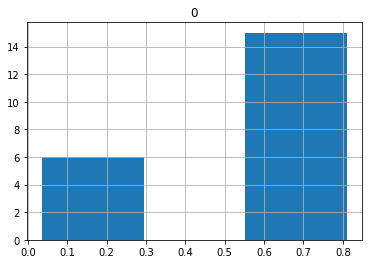

In [79]:
jaccard_dataframe.hist(bins = 3)

In [69]:
jaccard_matrix[-1][-3]

0.0

In [72]:
# Visualize violin seaborn plot
        